In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import lmdb
import pickle
from os.path import join
data_path = '/home/zhong/data/gopro_ds/'
lmdb_path = '/home/zhong/data/gopro_ds_lmdb/'
os.makedirs(lmdb_path, exist_ok=True)
for dataset_type in ['train', 'valid']:
    path = join(data_path, dataset_type)
    seqs = os.listdir(path)
    seqs_info = {}
    length = 0
    for i in range(len(seqs)):
        seq_info = {}
        seq_info['seq'] = seqs[i]
        length_temp = len(os.listdir(join(path,seqs[i],'blur_gamma')))
        seq_info['length'] = length_temp
        length += length_temp
        seqs_info[i] = seq_info
    seqs_info['length'] = length
    seqs_info['num'] = len(seqs)
    f = open(join(lmdb_path,'gopro_ds_info_{}.pkl'.format(dataset_type)), 'wb')
    pickle.dump(seqs_info, f)
    f.close()
    
    for dataset_label in [dataset_type, '{}_gt'.format(dataset_type)]:
        env = lmdb.open(join(lmdb_path, 'gopro_ds_'+dataset_label), map_size=1099511627776)
        txn = env.begin(write=True)
        for i in range(seqs_info['num']):
            if dataset_label.endswith('gt'):
                subpath = join(path, seqs_info[i]['seq'], 'sharp')
            else:
                subpath = join(path, seqs_info[i]['seq'], 'blur_gamma')
            imgs = os.listdir(subpath)
            nums = [int(img.split('.')[0]) for img in imgs]
            nums.sort()
            gap = nums[0]-0
            for img in imgs:
                img_path = join(subpath, img)
                seq_idx = i
                frame_idx = int(img.split('.')[0])-gap
                key = '%03d_%08d' % (seq_idx, frame_idx)
                data = cv2.imread(img_path)
                txn.put(key=key.encode(), value=data)
        txn.commit()
        env.close()

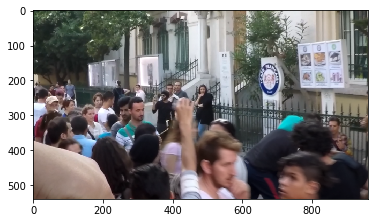

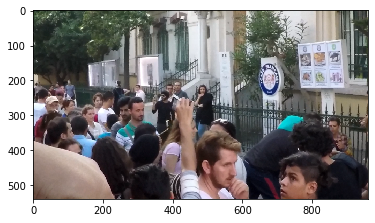

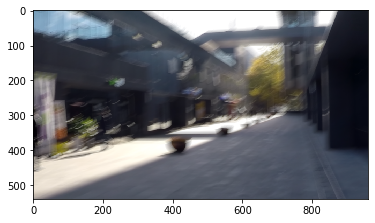

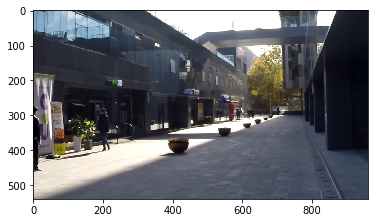

In [19]:
# test lmdb dataset
H,W,C = 540,960,3
# tarin set
env = lmdb.open(join(lmdb_path, 'gopro_ds_train'), map_size=1099511627776)
env_gt = lmdb.open(join(lmdb_path, 'gopro_ds_train_gt'), map_size=1099511627776)
txn = env.begin()
txn_gt = env_gt.begin()
seq = 21
frame = 39
key = '{:03d}_{:08d}'.format(seq, frame)
test = txn.get(key.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(H,W,C)
test_gt = txn_gt.get(key.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(H,W,C)
plt.imshow(test[:,:,::-1])
plt.figure()
plt.imshow(test_gt[:,:,::-1])
plt.show()
env.close()
env_gt.close()
# valid set
env = lmdb.open(join(lmdb_path, 'gopro_ds_valid'), map_size=1099511627776)
env_gt = lmdb.open(join(lmdb_path, 'gopro_ds_valid_gt'), map_size=1099511627776)
txn = env.begin()
txn_gt = env_gt.begin()
seq = 8
frame = 39
key = '{:03d}_{:08d}'.format(seq, frame)
test = txn.get(key.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(H,W,C)
test_gt = txn_gt.get(key.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(H,W,C)
plt.imshow(test[:,:,::-1])
plt.figure()
plt.imshow(test_gt[:,:,::-1])
plt.show()
env.close()
env_gt.close()